# Escalonamento de características e taxa de aprendizado

- Aluno: **Augusto Mathias Adams**

1. **Explique, com as suas próprias palavras, como a escolha do $\alpha$ afeta a convergência do Método do Gradiente.**

O tamanho do passo ou a taxa de aprendizado ($\alpha$) é indicativo de velocidade de convergência do Método do Gradiente. Contudo, se o valor de $\alpha$ for muito grande, o algoritmo pode dar passos excessivamente grandes, levando a uma oscilação em torno do mínimo, fazendo com que a função não convirja e, em casos extremos, podendo até divergir afastando-se do mínimo. Por outro lado, um valor de $\alpha$ muito pequeno resultará em passos pequenos, sendo que o algoritmo sempre converge para funções convexas, mas de forma lenta. O ideal é encontrar um valor de $alpha$ que equilibre a velocidade de convergência e a estabilidade. 

2. **Explique, com as suas próprias palavras, o que é o Escalonamento de Caracterı́sticas e qual o seu impacto no Método do Gradiente.**

O escalonamento de características é um pré-processamento de dados que visa normalizar ou padronizar as variáveis de entrada ou características, garantindo que a contribuição de cada variável seja equitativa para o aprendizado do modelo. Em algoritmos sensíveis à escala, como o Método do Gradiente estudado em aulas anteriores, o escalonamento de características auxilia na convergência mais rápida, na estabilidade numérica e evita a dominância de caracteristicas durante o aprendizado.

## Objetivos
Com este código você irá:
- Utilizar as rotinas de regressão linear múltipla desenvolvidas no último código
- Rodar o Método do Gradiente num conjunto de dados com múltiplas características
- Explorar o impacto da escolha da *taxa de aprendizado alpha* no Método do Gradiente
- Melhorar a performance do gradiente realizando o *Escalonamento de características* chamado *Normalização Z-score*

In [204]:
import math
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)  # reduz a precisão das numpy arrays na hora de dar print

# Definição do Problema

Usaremos um exemplo de motivação baseado no problema de estimar o preço de uma casa.

Os dados de treinamento contêm três exemplos com quatro características (Área, quartos, andares e idade). Note que a primeira característica possui uma ordem de grandeza muito maior que as demais. Note também que os dados são diferentes daqueles usados no código anterior. De fato, nesse código iremos usar um conjunto de dados com mais amostras (100 casas). Esse conjunto de dados encontra-se num arquivo individual denominado dados_casas.txt

## Conjunto de dados:
| Área (sqft) | quartos  | andares | Idade | preço (milháres de dólares)  |   
| ----------------| ------------------- |----------------- |--------------|----------------------- |  
| 952             | 2                   | 1                | 65           | 271.5                  |  
| 1244            | 3                   | 2                | 64           | 232                    |  
| 1947            | 3                   | 2                | 17           | 509.8                  |  
| ...             | ...                 | ...              | ...          | ...                    |


Você irá construir um modelo de regressão linear usando esses valores de tal forma que você também possa depois estimar o preço de outras casas. Por exemplo, um casa com 1200 sqft, 3 quartos, 1 andares, 40 anos.  



In [205]:
# Carregando os dados

file = open('dados_casas.txt') # As quatro primeiras colunas referem-se a características das casas.
                               # A quinta (última) coluna refere-se ao preço pelo qual tais casas foram negociadas
dados = np.loadtxt(file, delimiter=",")

print(type(dados)) # observa-se que os dados já estão no formato de numpy arrays

print(dados[0:10,:])  # mostra as primeiras 10 amostras dos dados

X_train = dados[:,0:4]
y_train = dados[:,-1] # pega apenas a última coluna. Seria o mesmo que y = dados[:,4]

print(X_train.shape)
print(y_train.shape)

X_caracteristicas = ['área','quartos','andares','idade']

<class 'numpy.ndarray'>
[[9.52e+02 2.00e+00 1.00e+00 6.50e+01 2.72e+02]
 [1.24e+03 3.00e+00 1.00e+00 6.40e+01 3.00e+02]
 [1.95e+03 3.00e+00 2.00e+00 1.70e+01 5.10e+02]
 [1.72e+03 3.00e+00 2.00e+00 4.20e+01 3.94e+02]
 [1.96e+03 3.00e+00 2.00e+00 1.50e+01 5.40e+02]
 [1.31e+03 2.00e+00 1.00e+00 1.40e+01 4.15e+02]
 [8.64e+02 2.00e+00 1.00e+00 6.60e+01 2.30e+02]
 [1.84e+03 3.00e+00 1.00e+00 1.70e+01 5.60e+02]
 [1.03e+03 3.00e+00 1.00e+00 4.30e+01 2.94e+02]
 [3.19e+03 4.00e+00 2.00e+00 8.70e+01 7.18e+02]]
(100, 4)
(100,)


Vamos visualizar o conjunto de dados e suas características plotando cada uma das características versus o tempo.

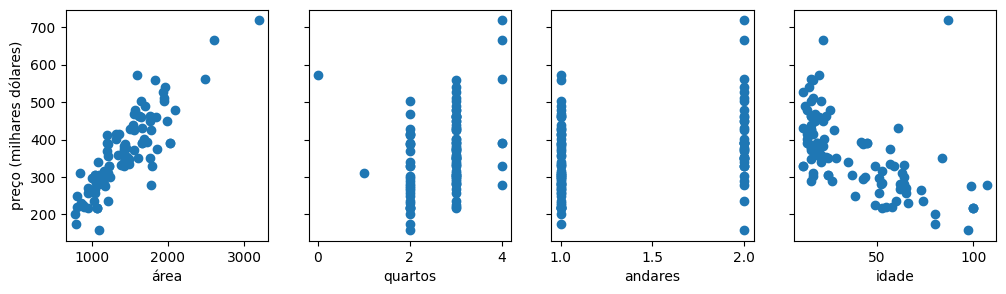

In [206]:
fig,ax=plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(X_caracteristicas[i])
ax[0].set_ylabel("preço (milhares dólares)")
plt.show()

Plotando cada característica versus o alvo y (no caso, o preço), conseguimos um indicativo de quais características possuem maior influência no preço. Como pode ser percebido, aumentar a área também aumenta o preço. Quartos e Andares não parecem ter um impacto tão grande no preço. Por fim, casas mais novas têm preços maiores em comparação com casas mais antigas.

## Revisitando o nosso código do Método do Gradiente

Abaixo nós estamos definindo novamente as 3 funções que implementam o Método do Gradiente (essas foram as funções desenvolvidas no último código).

In [207]:
def calcula_custo(X, y, w, b):
    """
    Calcula o custo
    Argumentos
      X (ndarray (m,n)): Dados, contendo m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros w do modelo
      b (scalar)       : parâmetro b do modelo

    Retorna:
      custo (escalar): custo
    """
    m     = X.shape[0]
    custo = 0.0
    for i in range(m):
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = escalar (see np.dot)
        custo = custo + (f_wb_i - y[i])**2     # escalar
    custo = custo / (2 * m)                    # escalar
    return custo

def calcula_gradiente(X, y, w, b):
    """
    Calcula Gradiente para Regressão Linear
    Args:
      X (ndarray (m,n)): Dados, contendo m exemplos com n características
      y (ndarray (m,)) : valores alvo
      w (ndarray (n,)) : parâmetros w do modelo
      b (scalar)       : parâmetro b do modelo

    Retorna:
      dj_dw (ndarray (n,)): O gradiente da função custo com relação aos parâmetros w.
      dj_db (escalar):      O gradiente da função custo com relação ao parâmetro b.
    """
    m,n = X.shape           #(número de exemplos, número de características)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):
        erro = (np.dot(X[i], w) + b) - y[i]
        for j in range(n):
            dj_dw[j] = dj_dw[j] + erro * X[i, j]
        dj_db = dj_db + erro
    dj_dw = dj_dw / m
    dj_db = dj_db / m

    return dj_db, dj_dw

def metodo_do_gradiente(X, y, w_in, b_in, calcula_custo, calcula_gradiente, alpha, num_iters):
    """
    Performa Método do Gradiente para aprender theta. Atualiza theta ao longo de
    num_iters passos de iteração usando uma taxa de aprendizado alpha

    Args:
      X (ndarray (m,n))   : Dados, contendo m exemplos com n características
      y (ndarray (m,))    : valores alvo
      w_in (ndarray (n,)) : valores iniciais dos parâmetros w do modelo
      b_in (escalar)      : valor inicial do parâmetro b do modelo
      calcula_custo       : função que calcula o custo
      calcula_gradiente   : função que calcula o gradiente
      alpha (float)       : taxa de aprendizado
      num_iters (int)     : Número de iterações para o método do gradiente

    Retorna:
      w (ndarray (n,)) : Valores atualizados para os parâmetros w
      b (scalar)       : Valores atualizado para o parâmetro b
      """

    # Valores históricos
    J_his = []
    w = w_in
    b = b_in

    for i in range(num_iters):

        # Calcula o gradiente
        dj_db,dj_dw = calcula_gradiente(X, y, w, b)   ##None

        # Atualiza os parâmetros
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None

        # Salva o custo
        if i<100000:      # prevent resource exhaustion
            J_his.append( calcula_custo(X, y, w, b))

        # Faz print de tempos em tempos
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteração {i:4d}: Custo {J_his[-1]:8.2f}   ")

    return w, b, J_his # retorna valores finais e históricos

<a name="toc_15456_5"></a>
## Abaixo nós testamos nossa implementação do Método do Gradiente para esse novo conjunto de dados, considerando um valor elevado para $\alpha$, $\alpha = 10 \times 10^{-7}$


Iteração    0: Custo 96598.21   
Iteração    1: Custo 131589.37   
Iteração    2: Custo 179465.09   
Iteração    3: Custo 244969.73   
Iteração    4: Custo 334594.59   
Iteração    5: Custo 457221.19   
Iteração    6: Custo 625001.40   
Iteração    7: Custo 854561.64   
Iteração    8: Custo 1168650.51   
Iteração    9: Custo 1598393.06   
b,w encontrados pelo método do gradiente: -0.00,[-0.96 -0.   -0.   -0.03] 


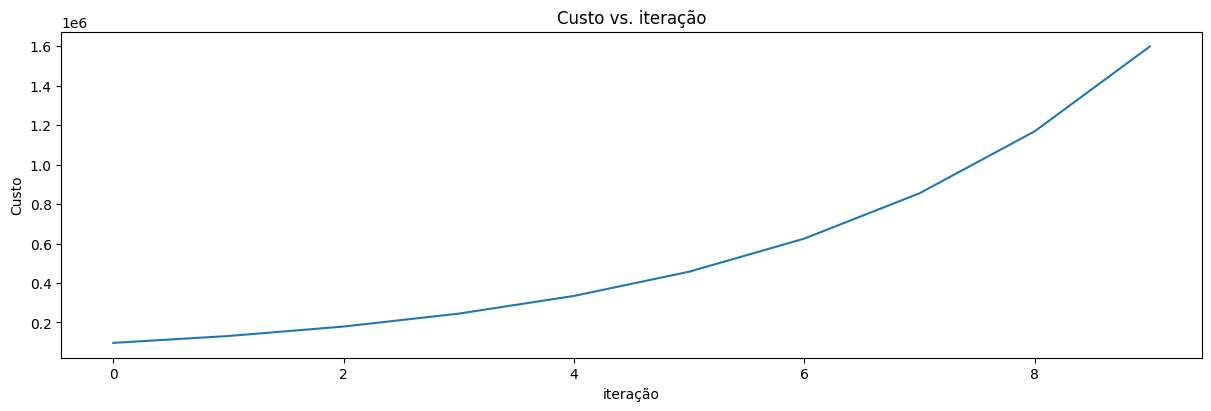

In [208]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0
# parâmetros para rodar o Método do Gradiente:
num_iters  = 10
alpha      = 10e-7
# Rodando o Método do gradiente
w_final, b_final, J_hist = metodo_do_gradiente(X_train, y_train, w_inicial, b_inicial,
                                                    calcula_custo, calcula_gradiente,
                                                    alpha, num_iters)
print(f"b,w encontrados pelo método do gradiente: {b_final:0.2f},{w_final} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()

A taxa de aprendizado parece estar muito grande. A solução não converge. O Custo está crescendo ao invés de diminuir.


## Agora considerando um valor menor, $\alpha = 1 \times 10^{-7}$


Iteração    0: Custo 44154.43   
Iteração    1: Custo 27679.69   
Iteração    2: Custo 17578.45   
Iteração    3: Custo 11385.01   
Iteração    4: Custo  7587.58   
Iteração    5: Custo  5259.23   
Iteração    6: Custo  3831.62   
Iteração    7: Custo  2956.29   
Iteração    8: Custo  2419.57   
Iteração    9: Custo  2090.48   
b,w encontrados pelo método do gradiente: 0.00,[2.31e-01 4.18e-04 2.12e-04 4.87e-03] 


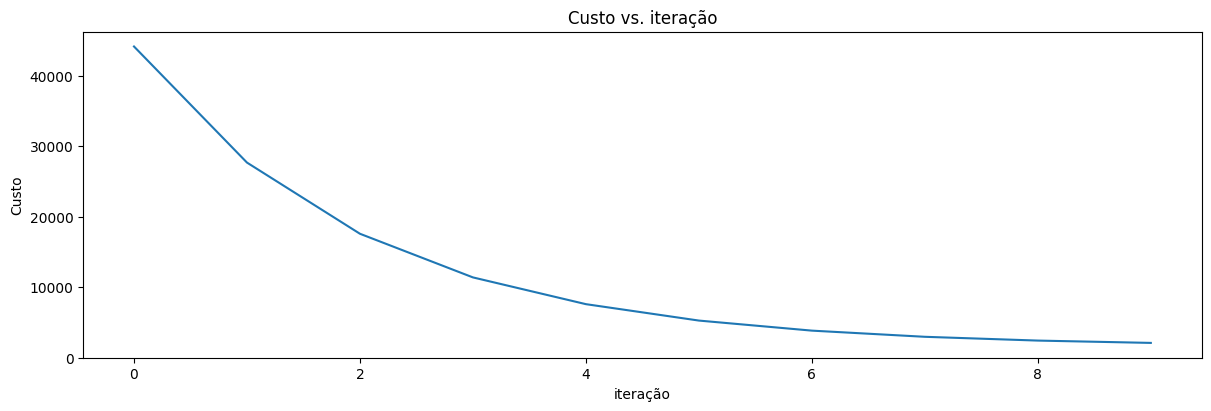

In [209]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0
# parâmetros para rodar o Método do Gradiente:
num_iters  = 10
alpha      = 1e-7
# Rodando o Método do gradiente
w_final, b_final, J_hist = metodo_do_gradiente(X_train, y_train, w_inicial, b_inicial,
                                                    calcula_custo, calcula_gradiente,
                                                    alpha, num_iters)
print(f"b,w encontrados pelo método do gradiente: {b_final:0.2f},{w_final} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()

O Custo está decrescendo ao longo das iterações. Isso significa que $\alpha$ não está muito grande para a função Custo como um todo.


## Testando um valor ainda menor, $\alpha = 0.1\times 10^{-7}$


Iteração    0: Custo 68042.86   
Iteração    1: Custo 65189.58   
Iteração    2: Custo 62458.78   
Iteração    3: Custo 59845.20   
Iteração    4: Custo 57343.80   
Iteração    5: Custo 54949.76   
Iteração    6: Custo 52658.49   
Iteração    7: Custo 50465.57   
Iteração    8: Custo 48366.77   
Iteração    9: Custo 46358.06   
b,w encontrados pelo método do gradiente: 0.00,[4.98e-02 9.08e-05 4.68e-05 1.12e-03] 


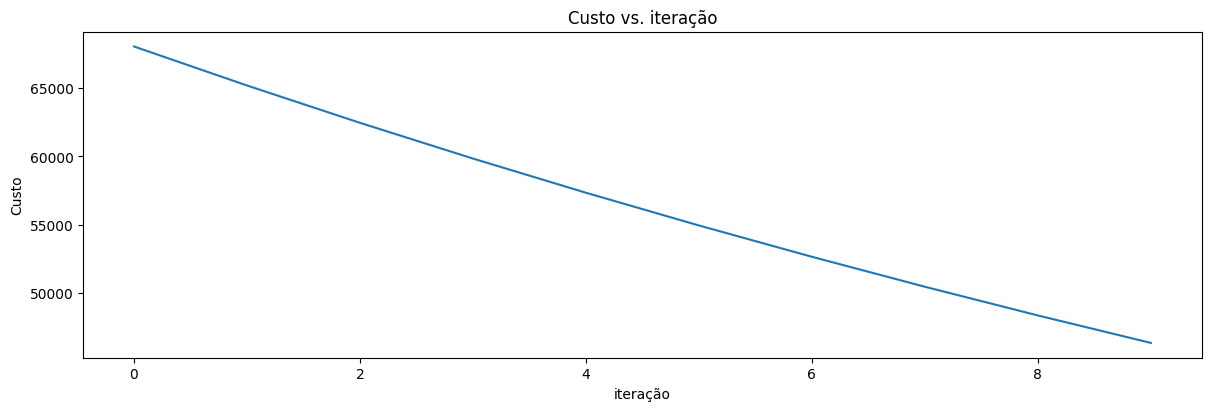

In [210]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0
# parâmetros para rodar o Método do Gradiente:
num_iters  = 10
alpha      = 0.1e-7
# Rodando o Método do gradiente
w_final, b_final, J_hist = metodo_do_gradiente(X_train, y_train, w_inicial, b_inicial,
                                                    calcula_custo, calcula_gradiente,
                                                    alpha, num_iters)
print(f"b,w encontrados pelo método do gradiente: {b_final:0.2f},{w_final} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()

O Custo está decrescendo ao longo das iterações. Isso significa que $\alpha$ não está muito grande. Entretanto, note que o custo encontra-se decaindo lentamente, o que indica um valor muito baixo para $\alpha$.

## Escalonamento de Características


Existem diferentes formas para se escalonar características:
- Dividindo pelo máximo: Nesse caso, essencialmente divide-se uma característica pelo seu valor máximo. Numa situação mais geral, é possível utilizar tanto o valor máximo como o mínimo, fazendo-se (x-min)/(max-min).
- Normalização pela média: Nesse caso, faz-se (x-media(x))/(max-min)
- Normalização Z-score: Nesse caso, faz-se (x-media(x))/(desvio)

>**OBSERVAÇÃO IMPORTANTE:** Ao normalizar características, é importante armazenar (guardar) os valores usados na normalização, média e desvio padrão no caso da normalização Z-score, por exemplo. Isso porque, após o modelo ser estimado, nós frequentemente queremos usar ele para estimar o preço de casas que não foram usadas no processo de treinamento. Dada uma nova casa com características x, nós devemos primeiro normalizar x usando a média e o desvio padrão que foram previamente computados a partir dos dados de treinamento.

A função abaixo implementa a normalização Z-Score

In [211]:
def normalizacao_zscore(X):
    """
    Normaliza todas as colunas em X

    Argumentos:
      X (ndarray (m,n))     : Dados de entrada, m amostras (linhas), n características (colunas)

    Retorna:
      X_norm (ndarray (m,n)): Matriz X normalizada
      mu (ndarray (n,))     : média de cada característica
      sigma (ndarray (n,))  : desvio padrão de cada característica
    """
    # Encontrando a média de cada característica/coluna
    mu     = np.mean(X, axis=0)                 # mu terá shape (n,) ---> axis=0 indica que a operação será feita ao longo das linhas, para cada coluna
    # Encontrando o desvio padrão de cada característica/coluna
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # O comando abaixo subtrai a média mu de cada coluna para cada exemplo, e divide pelo desvio correspondente
    X_norm = (X - mu) / sigma

    return (X_norm, mu, sigma)

#O que a nossa função faz pode ser feito usando a biblioteca Scikit learn, por meio dos comandos abaixo
#from sklearn.preprocessing import scale
#scale(X_orig, axis=0, with_mean=True, with_std=True, copy=True)

In [212]:
# Normalizando as características a partir da função normalizacao_zscore
X_norm, X_mu, X_sigma = normalizacao_zscore(X_train)
print(f"X_mu = {X_mu}, \nX_sigma = {X_sigma}")
print(f"Intervalo pico a pico por característica/coluna nos dados originais  :{np.ptp(X_train,axis=0)}")
print(f"Intervalo pico a pico por característica/coluna nos dados escalonados:{np.ptp(X_norm,axis=0)}")

X_mu = [1.41e+03 2.71e+00 1.38e+00 3.86e+01], 
X_sigma = [412.17   0.65   0.49  25.79]
Intervalo pico a pico por característica/coluna nos dados originais  :[2.41e+03 4.00e+00 1.00e+00 9.50e+01]
Intervalo pico a pico por característica/coluna nos dados escalonados:[5.84 6.13 2.06 3.68]


Com a normalização, o intervalo pico a pico para cada característica é reduzido de uma ordem de grandeza de milhares para uma ordem de gradeza de poucas unidades.

Iteração    0: Custo 34611.46   
Iteração   20: Custo   242.12   


Iteração   40: Custo   220.05   
Iteração   60: Custo   219.72   
Iteração   80: Custo   219.71   
Iteração  100: Custo   219.71   
Iteração  120: Custo   219.71   
Iteração  140: Custo   219.71   
Iteração  160: Custo   219.71   
Iteração  180: Custo   219.71   
b,w encontrados pelo método do gradiente: 362.24,[110.61 -21.47 -32.66 -37.78] 


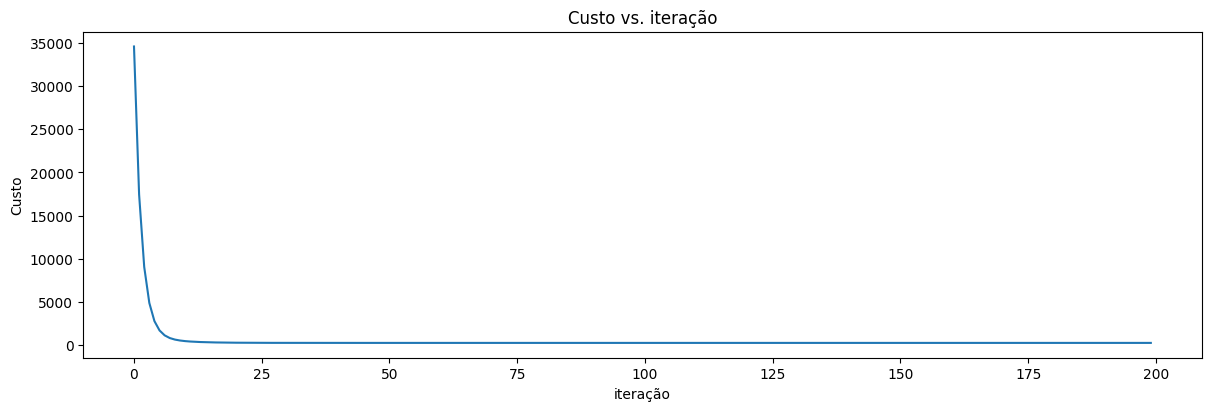

In [213]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0

# parâmetros para rodar o Método do Gradiente:
num_iters  = 200
alpha      = 0.3
# Rodando o Método do gradiente
w_norm, b_norm, J_hist = metodo_do_gradiente(X_norm, y_train, w_inicial, b_inicial,
                                                    calcula_custo, calcula_gradiente,
                                                    alpha, num_iters)
print(f"b,w encontrados pelo método do gradiente: {b_norm:0.2f},{w_norm} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()


As características escalonadas levam à resultados satisfatórios **mais rapidamente!**. Uma taxa de aprendizado de 0.1 ou 0.3 é geralmente um bom começo para regressão com características escalonadas.

Abaixo nós plotamos nossas previsões versus os valores alvo. Note, a previsão é feita usando as características normalizadas enquanto que o gráfico mostra os valores originais dessas características.

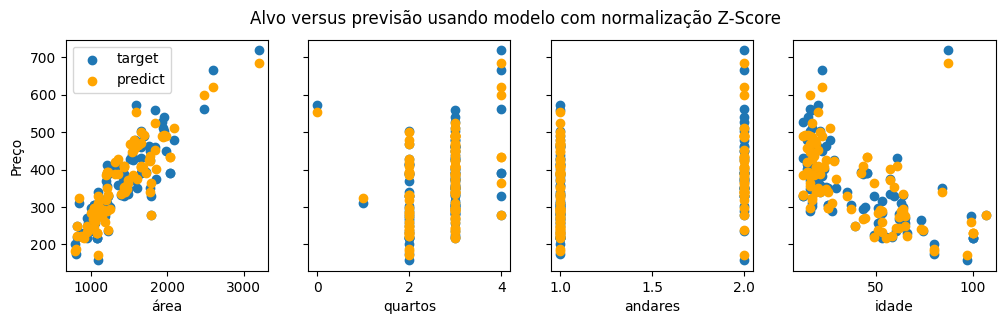

In [214]:
# realizando previsão usando características escalonadas
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# plotando alvo versus previsão
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_caracteristicas[i])
    ax[i].scatter(X_train[:,i],yp,color='orange', label = 'predict')
ax[0].set_ylabel("Preço"); ax[0].legend();
fig.suptitle("Alvo versus previsão usando modelo com normalização Z-Score")
plt.show()

Os resultados parecem satisfatórios. Algumas observações importantes:
- Com múltiplas características, Nós não conseguimos mais ter um único plot contendo resultados versus características.
- Ao gerar o plot, as caraterísticas normalizadas foram usadas. Qualquer previsão usando os parâmetros aprendidos a partir dos dados de treinamento normalizados também devem ser previamente normalizados.

**Previsão**
Agora que temos um modelo, podemos utilizá-lo para realizar a previsão do valor de casas que não estavam presentes no conjunto de 100 amostras que usamos para treinar o modelo. Vamos estimar o preço de uma casa com 1200 sqft, 3 quartos, 1 andar, 40 anos de idade. Lembre-se, você deve primeiramente normalizar os dados com a média e o desvio vindos dos dados de treinamento.

In [215]:
x_casa = np.array([1200, 3, 1, 40])
x_casa_norm = (x_casa - X_mu) / X_sigma
print(x_casa_norm)
y_casa = np.dot(x_casa_norm, w_norm) + b_norm
print(f" Preço estimado para uma casa com 1200 sqft, 3 quartos, 1 andar, 40 anos = ${y_casa*1000:0.0f}")

[-0.52  0.44 -0.78  0.05]
 Preço estimado para uma casa com 1200 sqft, 3 quartos, 1 andar, 40 anos = $318936



## Parabéns!

Com este código, você:
- utilizou as rotinas de regressão linear múltipla desenvolvidas em códigos anteriores
- explorou o impacto da taxa de aprendizado $\alpha$ na convergência do Método do Gradiente
- descobriu a importância do Escalonamento de Características usando a Normalização Z-Score para acelerar convergência

## Agradecimentos
Os dados foram obtidos da seguinte referência: [Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf). Tais dados foram compilados por Dean De Cock.

#### Happy Hour - Testando com os outros algoritmos que foram desenvolvidos nas últimas aulas

##### Algoritmo RMSProp

In [216]:
def rmsprop(X, y, w_in, b_in, alpha, num_iters, calcula_custo, calcula_gradiente, beta=0.9, epsilon=1e-8):
    """
    Aplica o método RMSProp para ajustar w, b para problemas multivariados.

    Argumentos da função:
      X (ndarray (m, n))  : Conjunto de dados com m exemplos e n características
      y (ndarray (m,))    : Valores alvo de saída
      w_in (ndarray (n,)) : Valores iniciais para os parâmetros w (vetor)
      b_in (escalar)      : Valor inicial para o parâmetro b
      alpha (float)       : Taxa de aprendizado
      num_iters (int)     : Número de iterações
      calcula_custo       : Função para calcular o custo
      calcula_gradiente   : Função para calcular o gradiente
      beta (float)        : Fator de decaimento para RMSProp (geralmente próximo de 0.9)
      epsilon (float)     : Pequeno valor para evitar divisão por zero no cálculo do gradiente (geralmente 1e-8)

    Retorna:
      w (ndarray (n,))    : Valor atualizado de w
      b (scalar)          : Valor atualizado de b
      J_history (list)    : Histórico dos valores de custo
    """

    # Inicializar variáveis
    J_history = []
    w = w_in
    b = b_in
    
    # Inicialização de acumuladores de gradiente como vetores do tamanho de w
    v_dw = np.zeros_like(w)  # Vetor do mesmo tamanho que w
    v_db = 0  # b é escalar

    for i in range(num_iters):
        # Calcula o gradiente
        dj_db, dj_dw = calcula_gradiente(X, y, w, b)

        # Atualiza os acumuladores RMSProp para w e b (element-wise para w)
        v_dw = beta * v_dw + (1 - beta) * (dj_dw**2)
        v_db = beta * v_db + (1 - beta) * (dj_db**2)

        # Atualiza os parâmetros w e b
        w = w - alpha * dj_dw / (np.sqrt(v_dw) + epsilon)
        b = b - alpha * dj_db / (np.sqrt(v_db) + epsilon)

        # Armazena o custo para cada iteração
        J_history.append(calcula_custo(X, y, w, b))
        
        # Exibe o progresso em intervalos regulares
        if i % (num_iters // 10) == 0 or i == num_iters - 1:
            print(f"Iteração {i:4d}: Custo {J_history[-1]:8.2f}")

    return w, b, J_history

##### Rodando o RMSProp

Iteração    0: Custo 68400.36
Iteração   30: Custo 47249.09
Iteração   60: Custo 34299.40
Iteração   90: Custo 23937.85
Iteração  120: Custo 15639.15
Iteração  150: Custo  9212.90
Iteração  180: Custo  4611.49
Iteração  210: Custo  1751.41
Iteração  240: Custo   453.20
Iteração  270: Custo   223.09
Iteração  299: Custo   222.00
b,w encontrados pelo método RMSProp: 362.24,[111.36 -20.72 -31.91 -38.53] 


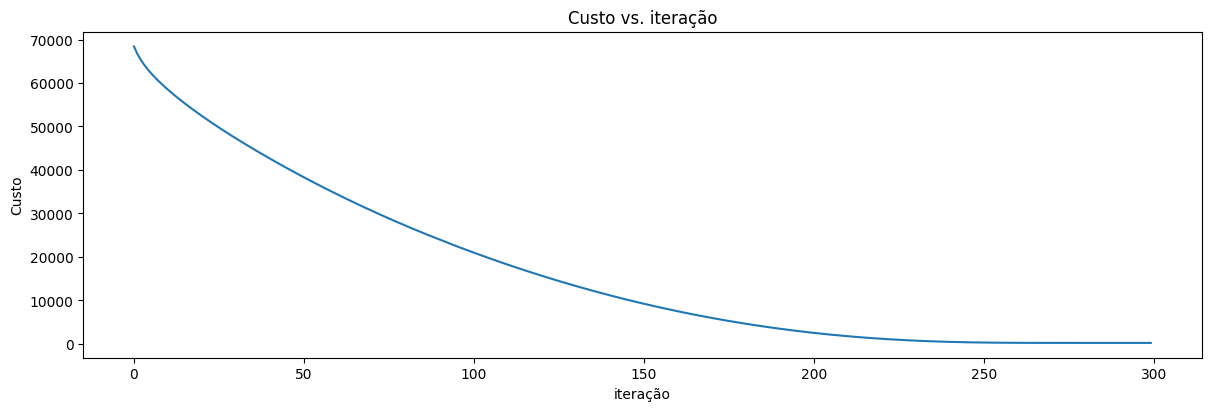

In [217]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0

# parâmetros para rodar o Método do Gradiente:
num_iters  = 300
alpha      = 1.5
# Rodando o Método do gradiente
w_norm, b_norm, J_hist = rmsprop(X_norm, y_train, w_inicial, b_inicial, alpha, num_iters,
                                                    calcula_custo, calcula_gradiente)
print(f"b,w encontrados pelo método RMSProp: {b_norm:0.2f},{w_norm} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()

##### Previsões com  $w_{norm}$ e $b_{norm}$ obtidos do RMSProp

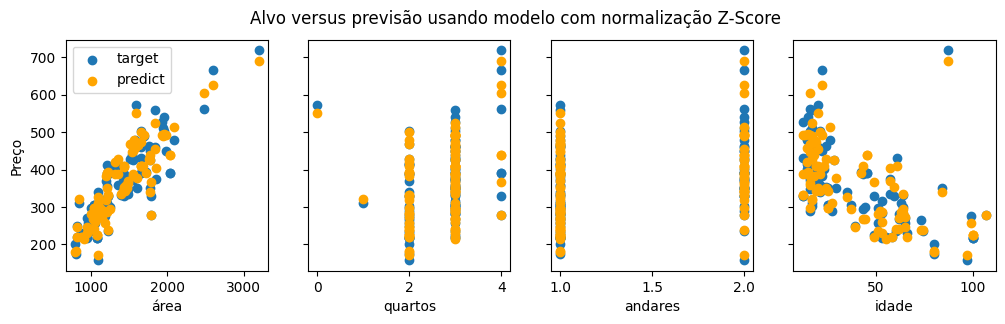

In [218]:
# realizando previsão usando características escalonadas
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# plotando alvo versus previsão
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_caracteristicas[i])
    ax[i].scatter(X_train[:,i],yp,color='orange', label = 'predict')
ax[0].set_ylabel("Preço"); ax[0].legend();
fig.suptitle("Alvo versus previsão usando modelo com normalização Z-Score")
plt.show()

##### Algoritmo SGD

In [219]:
def sgd(X, y, w_in, b_in, alpha, num_iters, calcula_custo, calcula_gradiente):
    """
    Aplica o Método do Gradiente Estocástico (SGD) para ajustar w, b.

    Argumentos da função:
      X (ndarray (m, n))   : Conjunto de dados com m exemplos e n características
      y (ndarray (m,))     : Valores alvo de saída
      w_in (ndarray (n,))  : Valores iniciais para os parâmetros w (vetor)
      b_in (scalar)        : Valor inicial para o parâmetro b
      alpha (float)        : Taxa de aprendizado
      num_iters (int)      : Número de iterações
      calcula_custo        : Função para calcular o custo
      calcula_gradiente    : Função para calcular o gradiente

    Retorna:
      w (ndarray (n,))     : Valor atualizado de w
      b (scalar)           : Valor atualizado de b
      J_history (list)     : Histórico dos valores de custo
    """

    # Inicializar variáveis
    J_history = []
    b = b_in
    w = w_in
    m = len(y)  # Número de amostras

    for i in range(num_iters):
        # Embaralhar os dados a cada iteração
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Atualiza w e b para cada exemplo de treinamento
        for j in range(m):
            # Seleciona uma única amostra (vetor de características e valor alvo)
            x_i = X_shuffled[j]   # Vetor (n,)
            y_i = y_shuffled[j]   # Escalar

            # Calcula o gradiente para essa amostra
            dj_db, dj_dw = calcula_gradiente(x_i.reshape(1, -1), np.array([y_i]), w, b)

            # Atualiza os parâmetros w e b
            w = w - alpha * dj_dw
            b = b - alpha * dj_db

        # Armazena o custo após a passagem por todo o conjunto de dados
        J_history.append(calcula_custo(X, y, w, b))

        # Exibe o progresso em intervalos regulares
        if i % (num_iters // 10) == 0 or i == num_iters - 1:
            print(f"Iteração {i:4d}: Custo {J_history[-1]:8.2f}")

    return w, b, J_history


##### Rodando o SGD

Iteração    0: Custo 46408.40
Iteração   20: Custo   323.10
Iteração   40: Custo   225.32
Iteração   60: Custo   220.02
Iteração   80: Custo   219.74
Iteração  100: Custo   219.72
Iteração  120: Custo   219.72
Iteração  140: Custo   219.74
Iteração  160: Custo   219.72
Iteração  180: Custo   219.73
Iteração  199: Custo   219.72
b,w encontrados pelo método SGD: 362.30,[110.65 -21.57 -32.72 -37.69] 


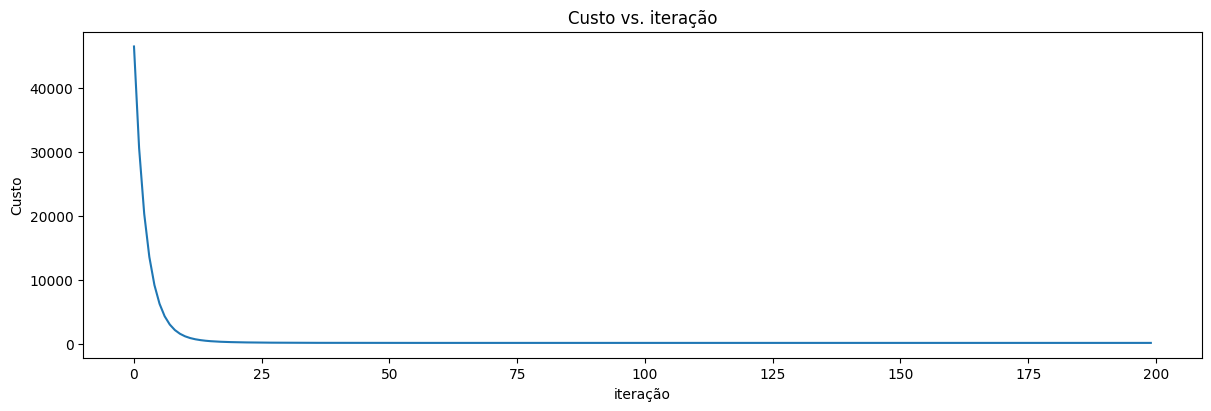

In [220]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0

# parâmetros para rodar o Método do Gradiente:
num_iters  = 200
alpha      = 2.1e-3
# Rodando o Método do gradiente
w_norm, b_norm, J_hist = sgd(X_norm, y_train, w_inicial, b_inicial, alpha, num_iters,
                                                    calcula_custo, calcula_gradiente)
print(f"b,w encontrados pelo método SGD: {b_norm:0.2f},{w_norm} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()

##### Previsões com $w_{norm}$ e $b_{norm}$ obtidos através do SGD

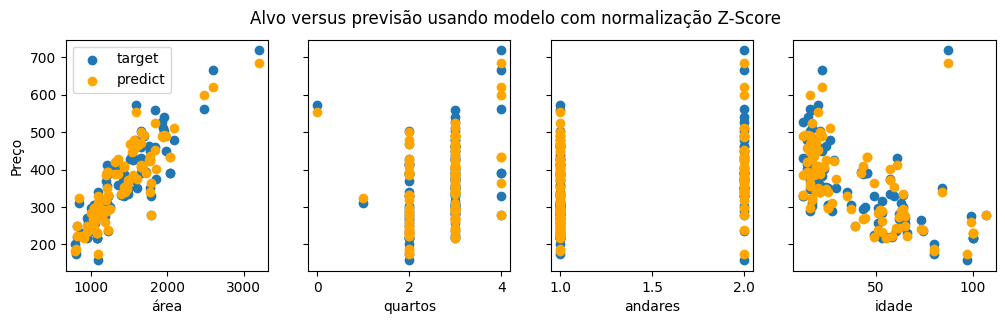

In [221]:
# realizando previsão usando características escalonadas
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# plotando alvo versus previsão
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_caracteristicas[i])
    ax[i].scatter(X_train[:,i],yp,color='orange', label = 'predict')
ax[0].set_ylabel("Preço"); ax[0].legend();
fig.suptitle("Alvo versus previsão usando modelo com normalização Z-Score")
plt.show()

##### Algoritmo do Gradiente Conjugado 

In [222]:
def gradiente_conjugado(x, y, w_in, b_in, alpha, num_iters, calcula_custo, calcula_gradiente, tol=1e-8):
    """
    Método de Gradiente Conjugado para ajuste de w e b.

    Argumentos:
      x (ndarray (m, n))  : Conjunto de dados com m amostras e n características
      y (ndarray (m,))    : Valores alvo de saída
      w_in (ndarray (n,)) : Vetor inicial para os parâmetros w
      b_in (scalar)       : Valor inicial para o parâmetro b
      alpha (float)       : Tamanho de passo ou taxa de aprendizado
      num_iters (int)     : Número de iterações
      calcula_custo       : Função para calcular o custo
      calcula_gradiente   : Função para calcular o gradiente
      tol (float)         : Tolerância para critério de parada

    Retorna:
      w (ndarray (n,))    : Valor atualizado de w
      b (scalar)          : Valor atualizado de b
      J_history (list)    : Histórico dos valores de custo
    """
    w = w_in
    b = b_in
    J_history = []

    g_prev_w = np.zeros(len(w))
    g_prev_b = 0
    p_w = -g_prev_w  # Inicializa como negativo do gradiente
    p_b = -g_prev_b

    for t in range(1, num_iters + 1):
        # Calcula o gradiente para w e b
        dj_db, dj_dw = calcula_gradiente(x, y, w, b)

        # Critério de parada baseado na norma do gradiente
        if np.sqrt(np.sum(dj_dw ** 2)) < tol and abs(dj_db) < tol:
            print(f"Convergência atingida na iteração {t}.")
            break

        # Primeira iteração - p inicial é o negativo do gradiente
        if t == 1:
            p_w = -dj_dw
            p_b = -dj_db
        else:
            # Computa beta_t usando o método Polak-Ribiére
            if np.dot(g_prev_w, g_prev_w) != 0:  # Prevenir divisão por zero
                beta_t = np.dot(dj_dw, dj_dw - g_prev_w) / np.dot(g_prev_w, g_prev_w)
            else:
                beta_t = 0  # Ou outra abordagem
            
            p_w = -dj_dw + beta_t * p_w
            p_b = -dj_db + beta_t * p_b

        # Atualiza os parâmetros
        w += alpha * p_w
        b += alpha * p_b

        # Calcula o custo e armazena no histórico
        J_history.append(calcula_custo(x, y, w, b))

        # Atualiza o gradiente anterior
        g_prev_w = dj_dw
        g_prev_b = dj_db

        # Exibe o progresso em intervalos regulares
        if t % (num_iters // 10) == 0 or t == num_iters:
            print(f"Iteração {t:4d}: Custo {J_history[-1]:8.2f}")

    return w, b, J_history


##### Rodando o Gradiente Conjugado

Iteração   20: Custo  2100.81
Iteração   40: Custo   384.81
Iteração   60: Custo   258.41
Iteração   80: Custo   230.10
Iteração  100: Custo   222.53
Iteração  120: Custo   220.48
Iteração  140: Custo   219.92
Iteração  160: Custo   219.77
Iteração  180: Custo   219.73
Iteração  200: Custo   219.72
b,w encontrados pelo método do gradiente conjugado: 362.24,[110.49 -21.41 -32.59 -37.8 ] 


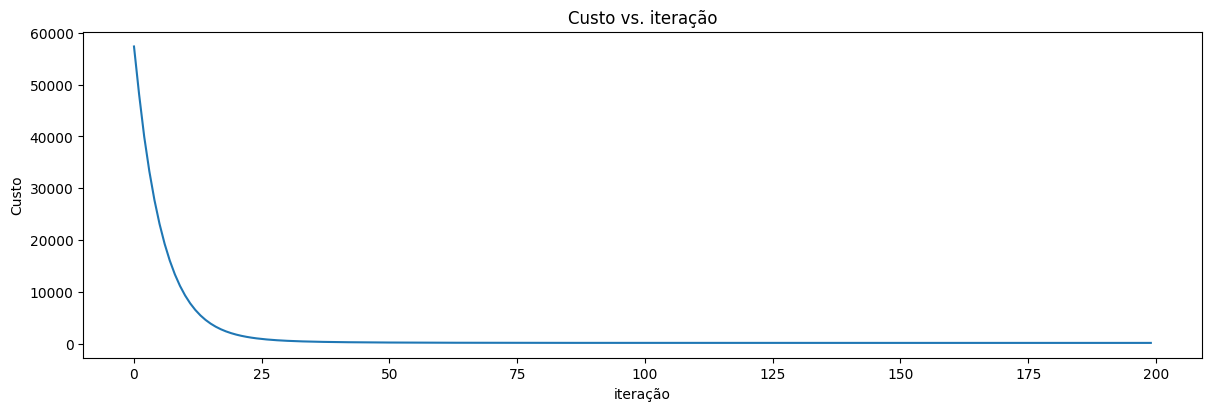

In [223]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0

# parâmetros para rodar o Método do Gradiente:
num_iters  = 200
alpha      = 1e-1
# Rodando o Método do gradiente
w_norm, b_norm, J_hist = gradiente_conjugado(X_norm, y_train, w_inicial, b_inicial, alpha, num_iters,
                                                    calcula_custo, calcula_gradiente)
print(f"b,w encontrados pelo método do gradiente conjugado: {b_norm:0.2f},{w_norm} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()

##### Previsões com $w_{norm}$ e $b_{norm}$ obtidos através do Gradente Conjugado

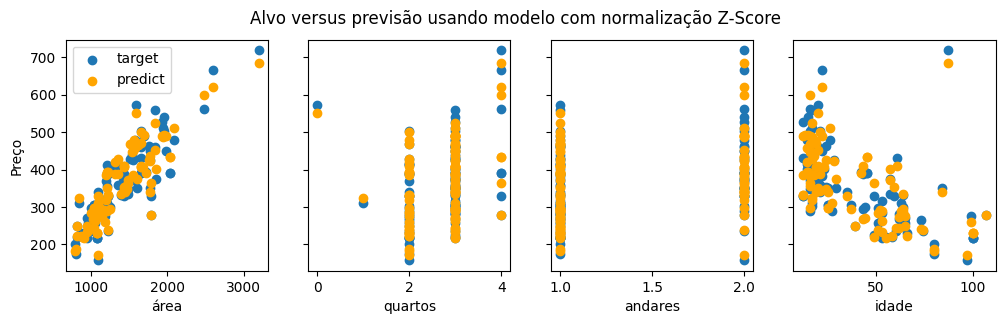

In [224]:
# realizando previsão usando características escalonadas
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# plotando alvo versus previsão
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_caracteristicas[i])
    ax[i].scatter(X_train[:,i],yp,color='orange', label = 'predict')
ax[0].set_ylabel("Preço"); ax[0].legend();
fig.suptitle("Alvo versus previsão usando modelo com normalização Z-Score")
plt.show()

##### Algoritmo Adam

In [225]:
def adam(x, y, w_in, b_in, alpha, beta1, beta2, epsilon, num_iters, calcula_custo, calcula_gradiente):
    """
    Aplica o algoritmo Adam para otimização de w e b em um cenário multivariado.

    Argumentos:
      x (ndarray): Conjunto de dados com m amostras e n características.
      y (ndarray): Valores alvo de saída.
      w_in (ndarray): Valores iniciais para os parâmetros w (vetor de pesos).
      b_in (scalar): Valor inicial para o parâmetro b (intercepto).
      alpha (float): Taxa de aprendizado.
      beta1 (float): Exponencial para a média dos gradientes.
      beta2 (float): Exponencial para a média dos gradientes ao quadrado.
      epsilon (float): Pequeno valor para evitar divisão por zero.
      num_iters (int): Número total de iterações.
      calcula_custo: Função que calcula o custo.
      calcula_gradiente: Função que calcula o gradiente.

    Retorna:
      w (ndarray): Valor otimizado de w (vetor de pesos).
      b (scalar): Valor otimizado de b (intercepto).
      J_history (list): Histórico dos valores de custo.
    """
    w = w_in
    b = b_in
    m_w, v_w = np.zeros_like(w), np.zeros_like(w)  # Inicialização dos momentos de w
    m_b, v_b = 0, 0  # Inicialização dos momentos de b

    J_history = []

    for t in range(1, num_iters + 1):
        # Calcula o gradiente
        dj_db, dj_dw = calcula_gradiente(x, y, w, b)

        # Atualiza as médias e variâncias dos gradientes (momentos)
        m_w = beta1 * m_w + (1 - beta1) * dj_dw
        m_b = beta1 * m_b + (1 - beta1) * dj_db

        v_w = beta2 * v_w + (1 - beta2) * (dj_dw ** 2)
        v_b = beta2 * v_b + (1 - beta2) * (dj_db ** 2)

        # Correções de bias
        m_w_corrigido = m_w / (1 - beta1 ** t)
        m_b_corrigido = m_b / (1 - beta1 ** t)
        v_w_corrigido = v_w / (1 - beta2 ** t)
        v_b_corrigido = v_b / (1 - beta2 ** t)

        # Atualiza os parâmetros
        w -= alpha * (m_w_corrigido / (np.sqrt(v_w_corrigido) + epsilon))
        b -= alpha * (m_b_corrigido / (np.sqrt(v_b_corrigido) + epsilon))

        # Armazena o custo atual
        J_history.append(calcula_custo(x, y, w, b))
        
        # Exibe o progresso em intervalos regulares
        if t % (num_iters // 10) == 0 or t == num_iters:
            print(f"Iteração {t:4d}: Custo {J_history[-1]:8.2f}   ")

    return w, b, J_history


##### Rodando o Adam

Iteração   20: Custo  8656.61   
Iteração   40: Custo   257.70   
Iteração   60: Custo   383.99   
Iteração   80: Custo   220.93   
Iteração  100: Custo   222.02   
Iteração  120: Custo   219.89   
Iteração  140: Custo   219.72   
Iteração  160: Custo   219.72   
Iteração  180: Custo   219.71   
Iteração  200: Custo   219.71   
b,w encontrados pelo método Adam: 362.24,[110.61 -21.47 -32.66 -37.78] 


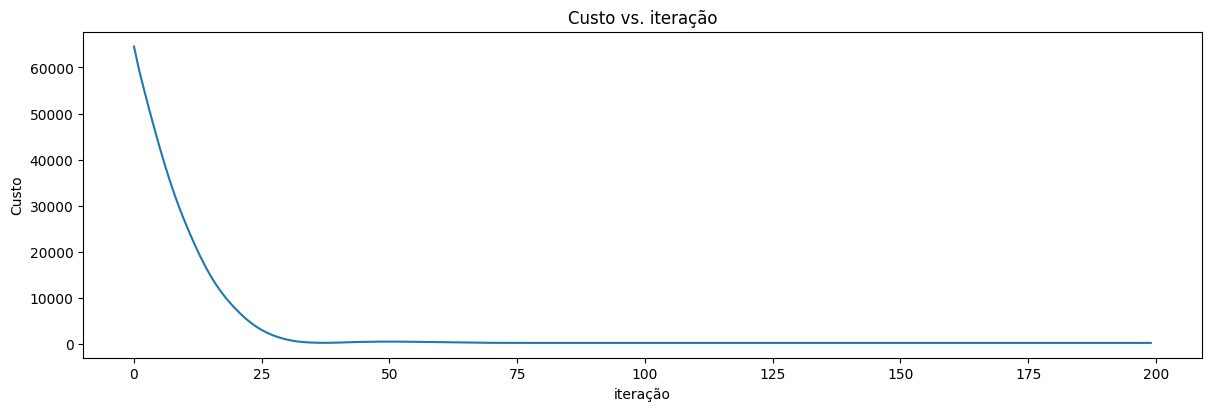

In [226]:
# inicializando parâmetros
w_inicial = np.array([ 0.0,  0.0,  0.0,  0.0])
b_inicial = 0.0

# parâmetros para rodar o Método do Gradiente:
num_iters  = 200
alpha  = 12.5
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

# Rodando o Método do gradiente
w_norm, b_norm, J_hist = adam(X_norm, y_train, w_inicial, b_inicial, alpha, beta1, beta2, epsilon, num_iters,
                                                    calcula_custo, calcula_gradiente)
print(f"b,w encontrados pelo método Adam: {b_norm:0.2f},{w_norm} ")

# Plotando os resultados
fig,ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 4))
ax.plot(J_hist)
ax.set_title("Custo vs. iteração")
ax.set_ylabel('Custo')
ax.set_xlabel('iteração')
plt.show()

#### Previsões com $w_{norm}$ e $b_{norm}$ obtidos pelo Adam

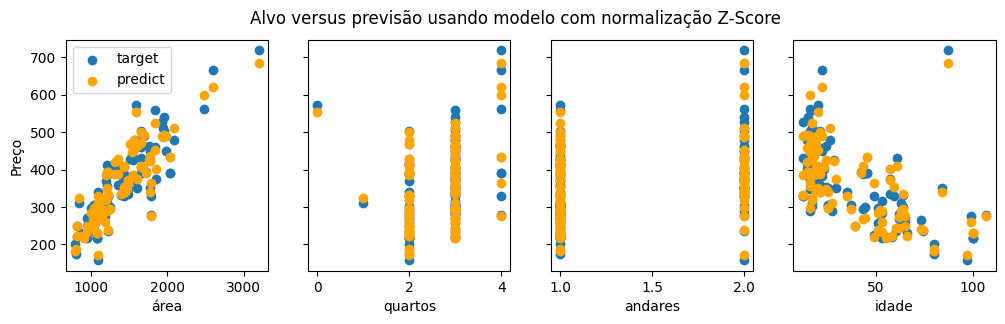

In [227]:
# realizando previsão usando características escalonadas
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_norm) + b_norm

# plotando alvo versus previsão
fig,ax=plt.subplots(1,4,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_caracteristicas[i])
    ax[i].scatter(X_train[:,i],yp,color='orange', label = 'predict')
ax[0].set_ylabel("Preço"); ax[0].legend();
fig.suptitle("Alvo versus previsão usando modelo com normalização Z-Score")
plt.show()

##### Considerações Finais

Os algoritmos testados tem performance comparável ao método do Gradiente, com as seguintes ressalvas:

- O RMSProp (pelo menos, a minha implementação) converge mais lentamente, mesmo para valores de $\alpha$ elevados. Provavelmente é caracteristica de implementação (Um enxerto do Goodfellow com Bonaccorso)
- O SGD é bem rápido na convergência, contudo, oscila para valores de $\alpha$ maiores que $10^{-2}$.
- O Gradiente Conjugado tem performance semelhante ao método do Gradiente.
- O Adam, embora seja robusto, é mais difícil de se ajustar (são 4 hiperparâmetros). Neste caso, é uma forma lenta de se obter um resultado semelhante (é derivado do RMSProp, se não me engano)